In [25]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import pickle
import datetime
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,os.path.dirname(os.path.dirname(currentdir)))

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Process Data

In [7]:
inmet_csv = './historical_data_florianopolis.csv'
save_scaler = "florianopolis_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 15*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      df_inmet.iloc[posicao_final-1,:].data,df_inmet.iloc[posicao_final-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
#pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
2019/12/17 0 2019/12/31 23


# SARIMAX 

## Auto ARIMA

In [15]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-780.158, Time=10.98 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-679.730, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-740.724, Time=5.37 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-719.903, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-681.682, Time=0.14 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-716.909, Time=5.68 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-734.116, Time=6.01 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-769.779, Time=19.59 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-773.740, Time=19.52 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-690.007, Time=0.99 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-726.636, Time=16.10 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-755.047, Time=19.44 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=-782.845, Time=24.40 sec
 ARIMA(1,1,2)(2,0,2)[24] intercept   : AIC=-778.570, Time=19.78 sec
 ARIMA(2,1,1

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 24),
      suppress_warnings=True)

In [16]:
mod = SARIMAX(endog=gen, exog=exog, order=(0, 1, 1), seasonal_order=(2, 0, 2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -695.2105245526302, Mape: 57.10640705924298


## PSO-ACO Parametrization

In [17]:
p = [0, 1, 2]
d = [0, 1, 2]
q = [0, 1, 2, 3]
sp = [0, 1, 2, 3]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-02-03 23:46:33,794 - root - INFO - Original search Space: [[0, 1, 2], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-03 23:46:33,794: INFO - Original search Space: [[0, 1, 2], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-03 23:46:33,797 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-03 23:46:33,797: INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-03 23:46:33,799 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-03 23:46:33,799: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-03 23:46:33,838 - root - INFO - 5
2021-02-03 23:46:33,838: INFO - 5
2021-02-03 23:46:33,987 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p':

ACO-All Best Response: [2 1 3]. Fitness: -677.9249506318147


2021-02-03 23:47:10,193 - root - INFO - ACO Search will start with PDQS: [ 1  0  2 24] and Exogenous Columns [1, 1, 0, 0, 0]

100%|██████████| 3/3 [03:52<00:00, 77.53s/it]
2021-02-03 23:51:02,788 - root - INFO - BEST result: [2 0 1].


ACO-All Best Response: [2 0 1]. Fitness: -717.4941939711166


2021-02-03 23:51:15,331 - root - INFO - ACO Search will start with PDQS: [ 1  0  1 24] and Exogenous Columns [1, 0, 1, 0, 0]

100%|██████████| 3/3 [00:55<00:00, 18.63s/it]
2021-02-03 23:52:11,211 - root - INFO - BEST result: [2 0 0].


ACO-All Best Response: [2 0 0]. Fitness: -759.42553537789


2021-02-03 23:52:14,306 - root - INFO - ACO Search will start with PDQS: [ 1  0  1 48] and Exogenous Columns [1, 0, 0, 0, 0]

100%|██████████| 3/3 [03:43<00:00, 74.43s/it]
2021-02-03 23:55:57,592 - root - INFO - BEST result: [2 0 0].


ACO-All Best Response: [2 0 0]. Fitness: -660.0799249597816


2021-02-03 23:56:06,273 - root - INFO - ACO Search will start with PDQS: [ 2  0  2 48] and Exogenous Columns [1, 0, 0, 1, 0]

100%|██████████| 3/3 [44:14<00:00, 884.79s/it]
2021-02-04 00:40:20,792 - root - INFO - BEST result: [1 0 3].


ACO-All Best Response: [1 0 3]. Fitness: 8113.952759782426


pyswarms.single.global_best:  33%|███▎      |1/3, best_cost=-.182021-02-04 00:41:35,490 - root - INFO - ACO Search will start with PDQS: [ 1  0  1 24] and Exogenous Columns [1, 1, 1]

100%|██████████| 3/3 [00:42<00:00, 14.16s/it]
2021-02-04 00:42:18,092 - root - INFO - BEST result: [1 0 0].


ACO-All Best Response: [1 0 0]. Fitness: -767.7503980223448


2021-02-04 00:42:18,991 - root - INFO - ACO Search will start with PDQS: [ 1  0  2 48] and Exogenous Columns [1, 0, 1, 1, 1]

100%|██████████| 3/3 [26:08<00:00, 522.98s/it]
2021-02-04 01:08:27,937 - root - INFO - BEST result: [1 0 2].


ACO-All Best Response: [1 0 2]. Fitness: 9639.870716101119


2021-02-04 01:10:41,867 - root - INFO - ACO Search will start with PDQS: [ 1  0  1 24] and Exogenous Columns [1, 1, 0, 1]

100%|██████████| 3/3 [00:54<00:00, 18.28s/it]
2021-02-04 01:11:36,699 - root - INFO - BEST result: [2 0 2].


ACO-All Best Response: [2 0 2]. Fitness: -754.4754550163614


2021-02-04 01:11:39,919 - root - INFO - ACO Search will start with PDQS: [ 2  0  1 48] and Exogenous Columns [1, 1, 1, 1]

100%|██████████| 3/3 [27:46<00:00, 555.35s/it]
2021-02-04 01:39:25,968 - root - INFO - BEST result: [1 0 0].


ACO-All Best Response: [1 0 0]. Fitness: -575.709061385906


2021-02-04 01:40:29,250 - root - INFO - ACO Search will start with PDQS: [ 2  0  2 48] and Exogenous Columns [1, 0, 0, 0, 0]

100%|██████████| 3/3 [25:13<00:00, 504.35s/it]
2021-02-04 02:05:42,327 - root - INFO - BEST result: [1 1 2].


ACO-All Best Response: [1 1 2]. Fitness: 7658.761477672121


pyswarms.single.global_best:  67%|██████▋   |2/3, best_cost=-.182021-02-04 02:07:32,971 - root - INFO - ACO Search will start with PDQS: [ 2  0  2 24] and Exogenous Columns [1, 1, 1]

100%|██████████| 3/3 [03:22<00:00, 67.41s/it]
2021-02-04 02:10:55,228 - root - INFO - BEST result: [1 0 0].


ACO-All Best Response: [1 0 0]. Fitness: -730.2843944442859


2021-02-04 02:11:04,241 - root - INFO - ACO Search will start with PDQS: [ 1  0  2 48] and Exogenous Columns [1, 1, 1, 0]

100%|██████████| 3/3 [22:50<00:00, 456.88s/it]
2021-02-04 02:33:56,701 - root - INFO - BEST result: [2 0 3].


ACO-All Best Response: [2 0 3]. Fitness: 8263.420042228663


2021-02-04 02:35:51,524 - root - INFO - ACO Search will start with PDQS: [ 1  0  1 24] and Exogenous Columns [1, 1, 0]

100%|██████████| 3/3 [00:44<00:00, 14.80s/it]
2021-02-04 02:36:35,933 - root - INFO - BEST result: [1 0 0].


ACO-All Best Response: [1 0 0]. Fitness: -769.1370028450112


2021-02-04 02:36:37,511 - root - INFO - ACO Search will start with PDQS: [ 2  0  1 48] and Exogenous Columns [1, 1, 0, 0]

100%|██████████| 3/3 [34:30<00:00, 690.33s/it]
2021-02-04 03:11:08,487 - root - INFO - BEST result: [1 0 0].


ACO-All Best Response: [1 0 0]. Fitness: -576.2197368992144


2021-02-04 03:13:45,985 - root - INFO - ACO Search will start with PDQS: [ 1  0  2 48] and Exogenous Columns [1, 0, 1, 1]

100%|██████████| 3/3 [22:53<00:00, 457.92s/it]
2021-02-04 03:36:39,761 - root - INFO - BEST result: [1 0 3].


ACO-All Best Response: [1 0 3]. Fitness: 8930.90285425398


pyswarms.single.global_best: 100%|██████████|3/3, best_cost=-.18
2021-02-04 03:38:39,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.18040109319729897, best pos: [0.94039422 0.17522011 1.08369469 0.52735225 6.37145761]
2021-02-04 03:38:40,066 - root - INFO - Global best result: pdq=[2 0 2], pdqs=[ 1  0  1 24], X=[1, 1, 0, 1]


Mape: 52.31635429854408


In [24]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,1,0,1]], order=(2,0,2), seasonal_order=(1,0,1,24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -754.4754550163614, Mape: 52.31635429854408


## DUMP Sarimax

In [19]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

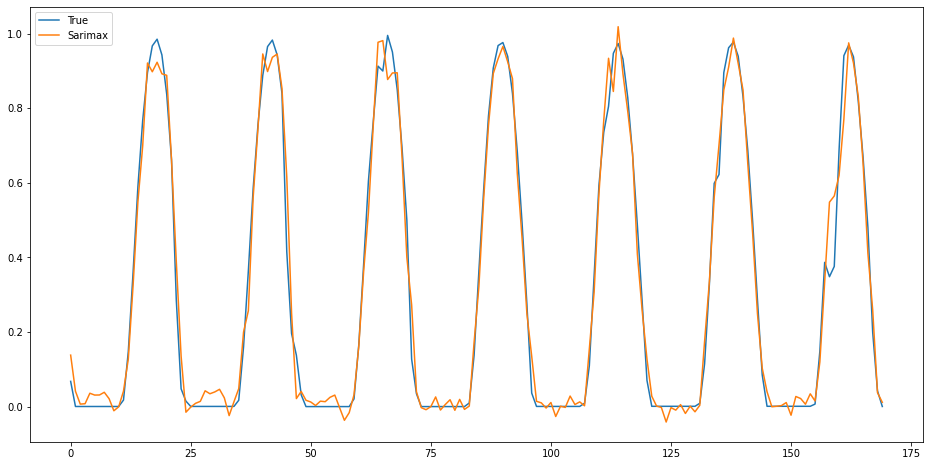

In [8]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [15]:
ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
                                 tr_ts_percents=tr_ts_percents).search_best_model()
best_mlp_residual = ag_mlp_residual._best_of_all
pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0



100%|██████████| 3/3 [00:07<00:00,  2.54s/it]

100%|██████████| 3/3 [00:31<00:00, 10.49s/it]

100%|██████████| 3/3 [00:30<00:00, 10.32s/it]

100%|██████████| 3/3 [00:48<00:00, 16.16s/it]

100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

100%|██████████| 3/3 [00:38<00:00, 12.96s/it]

100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

100%|██████████| 3/3 [00:29<00:00,  9.70s/it]

100%|██████████| 3/3 [00:00<00:00, 15.63it/s]

100%|██████████| 3/3 [00:08<00:00,  2.97s/it]

100%|██████████| 3/3 [00:00<00:00,  8.73it/s]

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

100%|██████████| 3/3 [00:10<00:00,  3.53s/it]

100%|██████████| 3/3 [00:52<00:00, 17.58s/it]

100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

100%|██████████| 3/3 [00:08<00:00,  2.96s/it]

100%|██████████| 3/3 [00:45<00:00, 15.17s/it]

100%|██████████| 3/3 [00:08<00:00,  2.73s/it]

100%|███████

generation: 1



100%|██████████| 3/3 [00:05<00:00,  1.79s/it]

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]

100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

100%|██████████| 3/3 [00:08<00:00,  2.81s/it]

100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

100%|██████████| 3/3 [00:45<00:00, 15.12s/it]

100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

100%|██████████| 3/3 [01:03<00:00, 21.33s/it]

100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

100%|██████████| 3/3 [00:34<00:00, 11.55s/it]

100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

100%|██████████| 3/3 [00:19<00:00,  6.63s/it]

100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

100%|██████████| 3/3 [00:23<00:00,  7.99s/it]

100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

100%|██████████| 3/3 [00:15<00:00,  5.22s/it]

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]

100%|██████████| 3/3 [00:28<00:00,  9.40s/it]

100%|██████████| 3/3 [00:14<00:00,  4.76s/it]

 67%|██████▋   | 2/3 [18:14<09:33, 573.88s/it]

generation: 2



100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

100%|██████████| 3/3 [00:57<00:00, 19.01s/it]

100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

100%|██████████| 3/3 [00:37<00:00, 12.53s/it]

100%|██████████| 3/3 [00:12<00:00,  4.04s/it]

100%|██████████| 3/3 [00:44<00:00, 14.87s/it]

100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

100%|██████████| 3/3 [00:08<00:00,  2.96s/it]

100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

100%|██████████| 3/3 [00:44<00:00, 14.84s/it]

100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

100%|██████████| 3/3 [00:10<00:00,  3.47s/it]

100%|██████████| 3/3 [00:13<00:00,  4.57s/it]

100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

100%|██████████| 3/3 [25:02<00:00, 500.79s/it]


## Análise Resultados

[4, 17, 8, 6, MLPRegressor(early_stopping=True, hidden_layer_sizes=(7, 3, 10), max_iter=500,
             solver='sgd'), MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(62, 38, 4), learning_rate='adaptive',
             max_iter=500, solver='lbfgs'), 0.028002818812420116]
Teste para saber se pegou o melhor mesmo! 0.028002818812420123 == 0.028002818812420116 ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.033708576676019286
MSE:  0.002786335020643927
MAPE:  7.634952828961691
HIBRIDO
MAE:  0.028002818812420123
MSE:  0.0022218377504914432
MAPE:  1.4620458116675676
GANHO MAE:
0.16926724371777802
GANHO MSE:
0.2025949018944705
GANHO MAPE:
0.8085062416991518


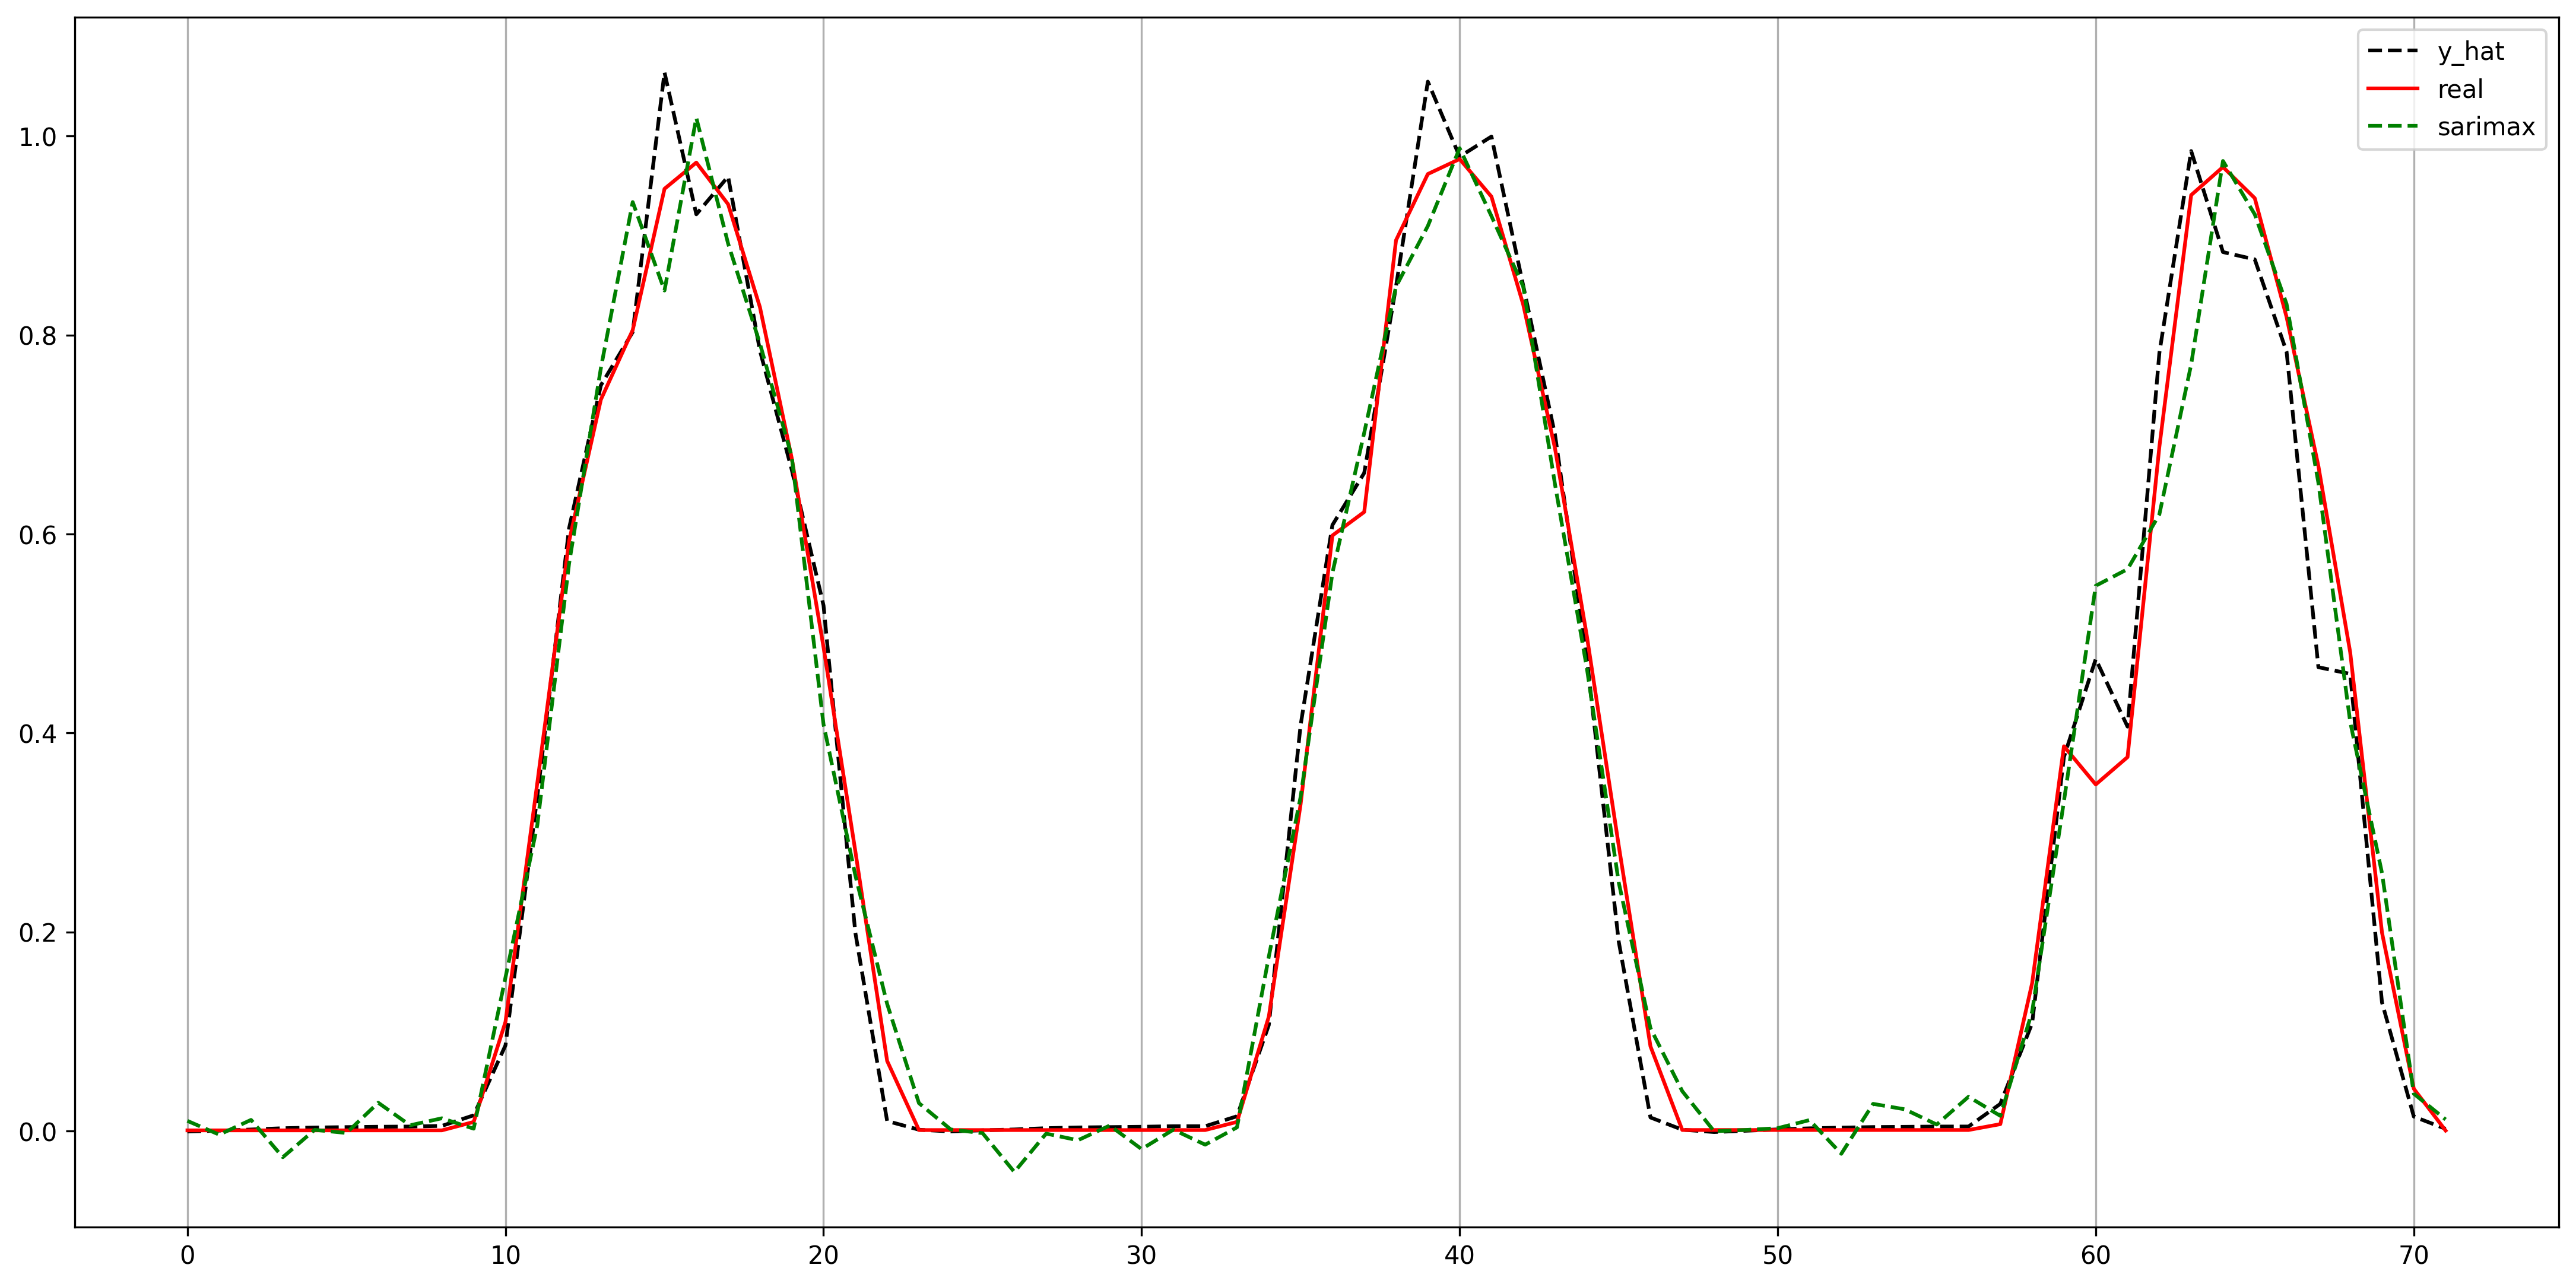

In [9]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best_mlp_residual = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best_mlp_residual[0],
                                                                                            tr_ts_percents)
erro_estimado = np.concatenate((best_mlp_residual[4].predict(erro_train_entrada),
                                best_mlp_residual[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best_mlp_residual[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best_mlp_residual[2],
                                                                best_mlp_residual[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best_mlp_residual[5].predict(X_in_train), best_mlp_residual[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best_mlp_residual[5].predict(X_in_test)

len_dt = len(data_test)

print(best_mlp_residual)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test,
                                                                        data_test),best_mlp_residual[6]))
print (mae(y_estimado_so_test, data_test) ==  best_mlp_residual[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

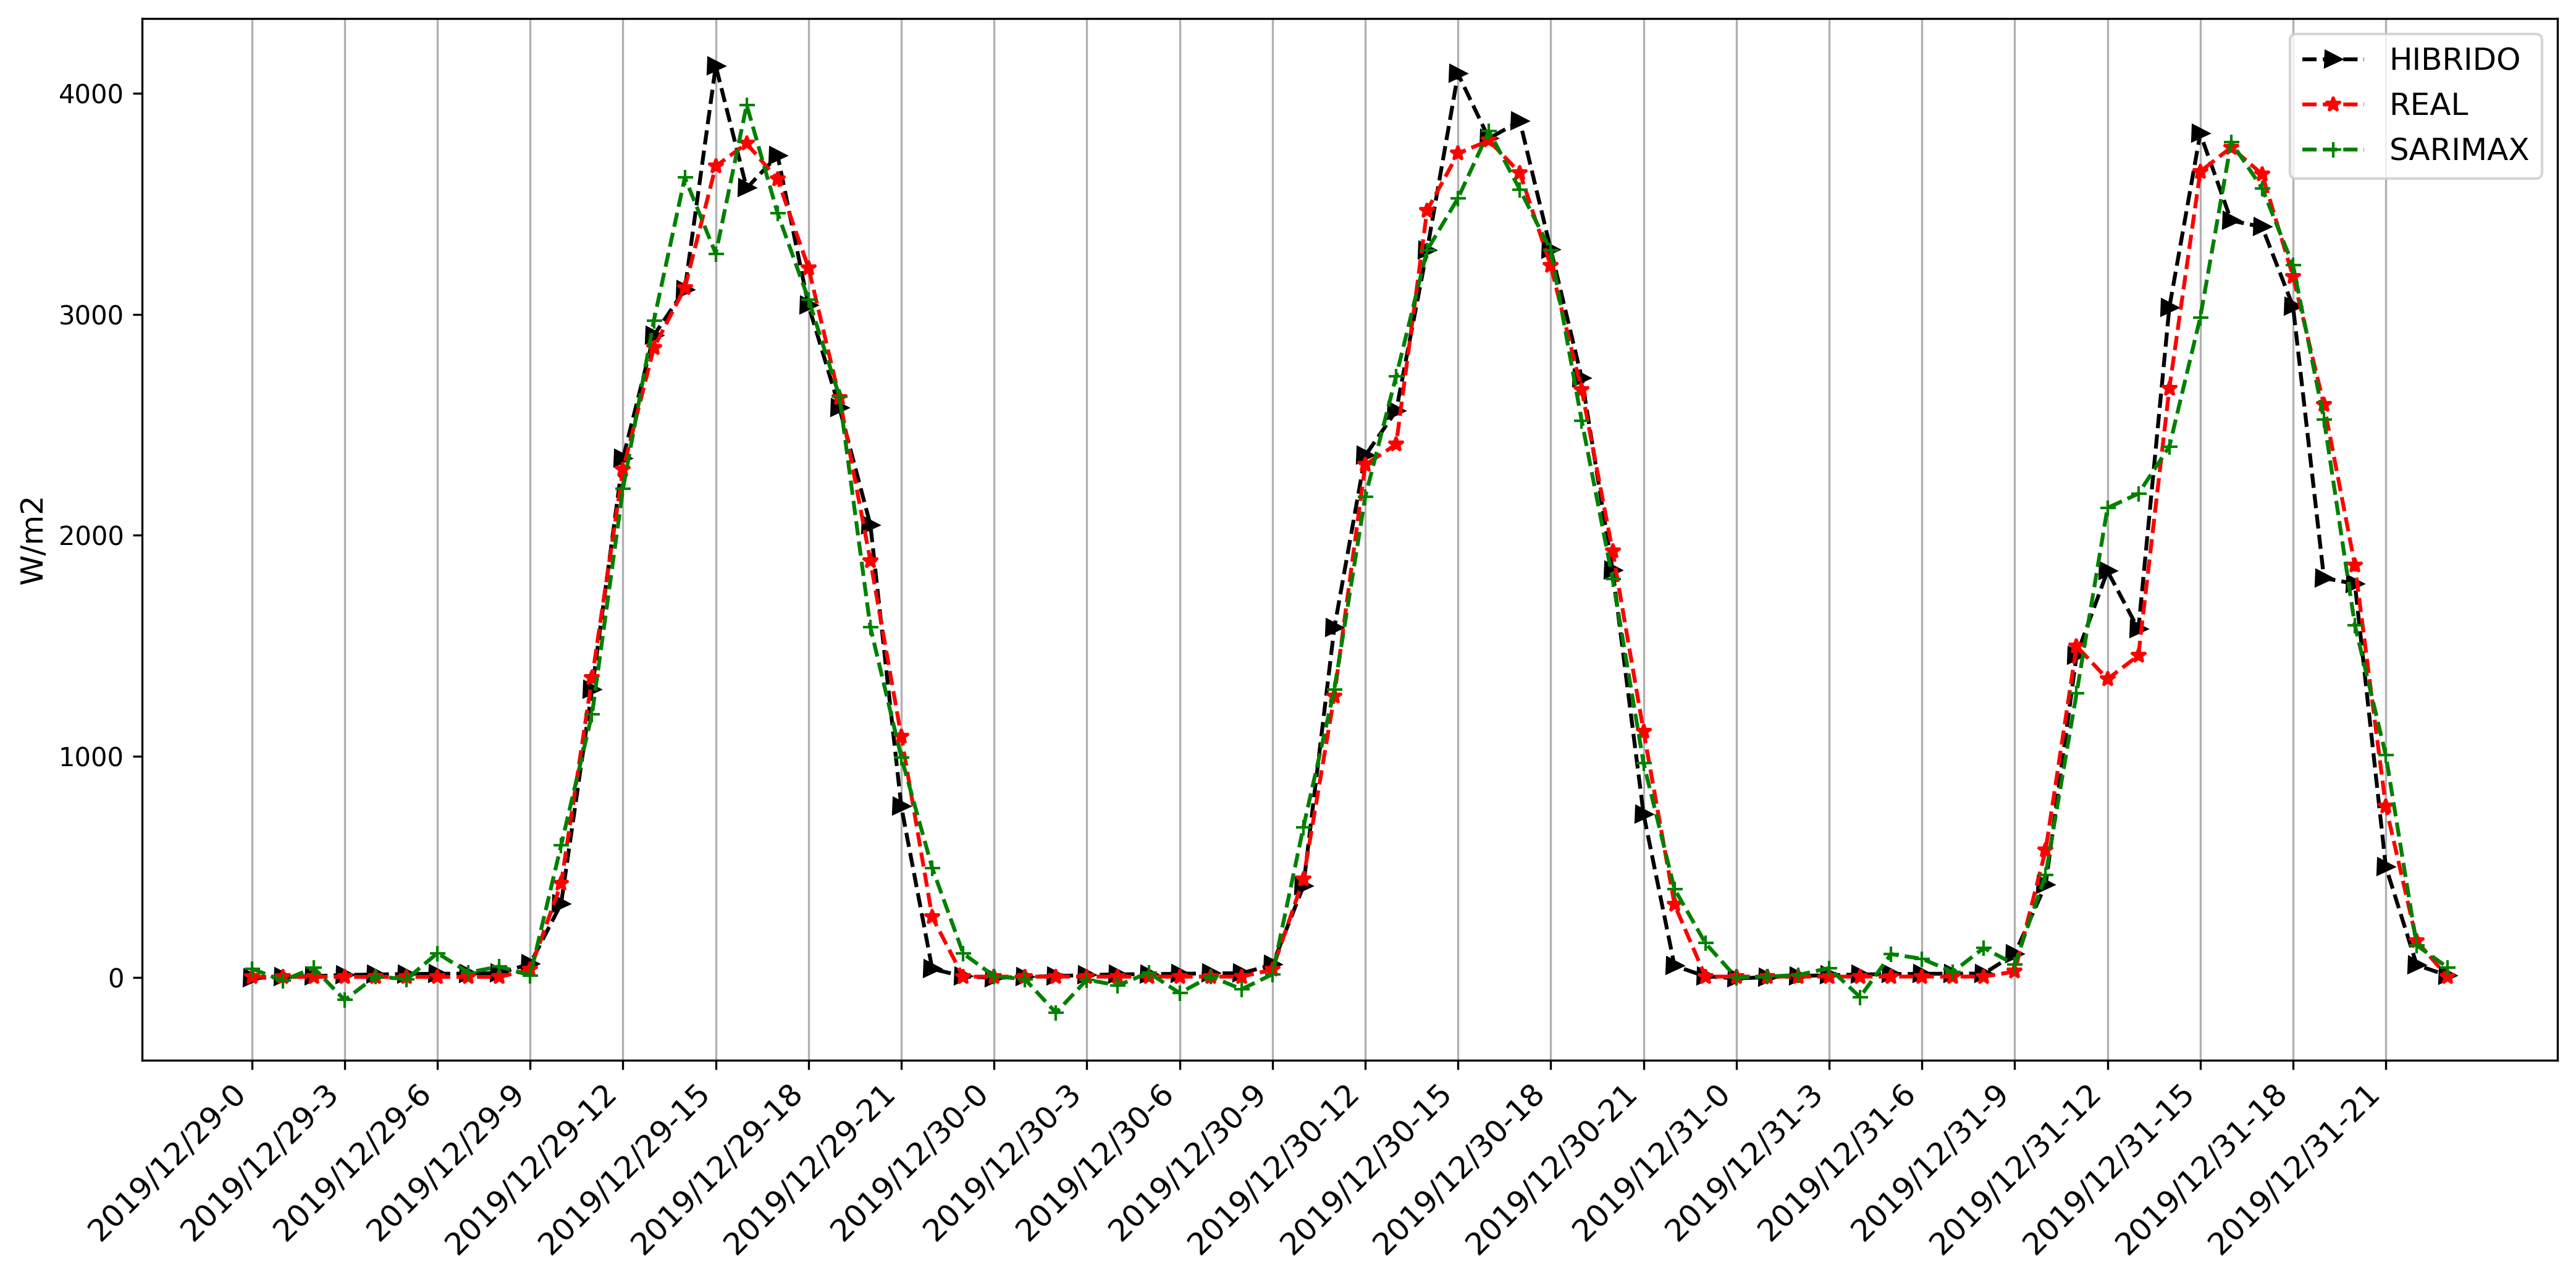

In [19]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

len_dt = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

## Train

In [ ]:
tr_ts_percents=[80,20]

In [16]:
# ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
#                                        prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

# best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

# pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0



100%|██████████| 3/3 [00:05<00:00,  1.91s/it]

100%|██████████| 3/3 [00:18<00:00,  6.16s/it]

100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

100%|██████████| 3/3 [00:16<00:00,  5.62s/it]

100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

100%|██████████| 3/3 [00:14<00:00,  4.78s/it]

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]

100%|██████████| 3/3 [00:11<00:00,  3.77s/it]

100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

100%|██████████| 3/3 [00:11<00:00,  3.89s/it]

100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

100%|██████████| 3/3 [00:27<00:00,  9.12s/it]

100%|██████████| 3/3 [00:06<00:00,  2.27s/it]

100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

100%|██████████| 3/3 [00:06<00:00,  2.28s/it]

100%|██████████| 3/3 [00:09<00:00,  3.12s/it]

100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

100%|██████████| 3/3 [00:14<00:00,  4.92s/it]

100%|██████████| 3/3 [00:16<00:00,  5.44s/it]

100%|███████

generation: 1
start_set_fit: 2



100%|██████████| 3/3 [00:06<00:00,  2.12s/it]

100%|██████████| 3/3 [00:13<00:00,  4.52s/it]

100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

100%|██████████| 3/3 [00:09<00:00,  3.23s/it]

100%|██████████| 3/3 [00:15<00:00,  5.19s/it]

100%|██████████| 3/3 [00:17<00:00,  5.93s/it]

100%|██████████| 3/3 [00:11<00:00,  3.74s/it]

100%|██████████| 3/3 [00:18<00:00,  6.04s/it]

100%|██████████| 3/3 [00:11<00:00,  3.68s/it]

100%|██████████| 3/3 [00:23<00:00,  7.91s/it]

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

100%|██████████| 3/3 [00:19<00:00,  6.39s/it]

100%|██████████| 3/3 [00:10<00:00,  3.57s/it]

100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

100%|██████████| 3/3 [00:05<00:00,  1.81s/it]

100%|██████████| 3/3 [00:21<00:00,  7.16s/it]

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

100%|██████████| 3/3 [00:19<00:00,  6.42s/it]

100%|██████████| 3/3 [00:06<00:00,  2.00s/it]

 67%|██████▋   | 2/3 [12:28<06:23, 383.46s/it]

generation: 2
start_set_fit: 4



100%|██████████| 3/3 [00:09<00:00,  3.30s/it]

100%|██████████| 3/3 [00:16<00:00,  5.34s/it]

100%|██████████| 3/3 [00:09<00:00,  3.03s/it]

100%|██████████| 3/3 [00:19<00:00,  6.40s/it]

100%|██████████| 3/3 [00:07<00:00,  2.48s/it]

100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

100%|██████████| 3/3 [00:28<00:00,  9.59s/it]

100%|██████████| 3/3 [00:06<00:00,  2.10s/it]

100%|██████████| 3/3 [00:09<00:00,  3.25s/it]

100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

100%|██████████| 3/3 [00:08<00:00,  2.89s/it]

100%|██████████| 3/3 [00:17<00:00,  5.78s/it]

100%|██████████| 3/3 [00:07<00:00,  2.48s/it]

100%|██████████| 3/3 [16:58<00:00, 339.38s/it]


## Análise Resultados

[17, 19, 7, 6, 2, <mlopt.AgMlp.AgMlp object at 0x00000222D6C1AD60>, <mlopt.AgMlp.AgMlp object at 0x00000223A6C03DC0>, 0.023722002437145992]
Teste para saber se pegou o melhor mesmo! 0.023722002437145975 == <mlopt.AgMlp.AgMlp object at 0x00000223A6C03DC0> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.033708576676019286
MSE:  0.002786335020643927
MAPE:  7.634952828961691
HIBRIDO
MAE:  0.023722002437145975
MSE:  0.0024074512692931153
MAPE:  0.9386230904390668
GANHO MAE:
0.29626211556947435
GANHO MSE:
0.13597925179264736
GANHO MAPE:
0.8770623589344803


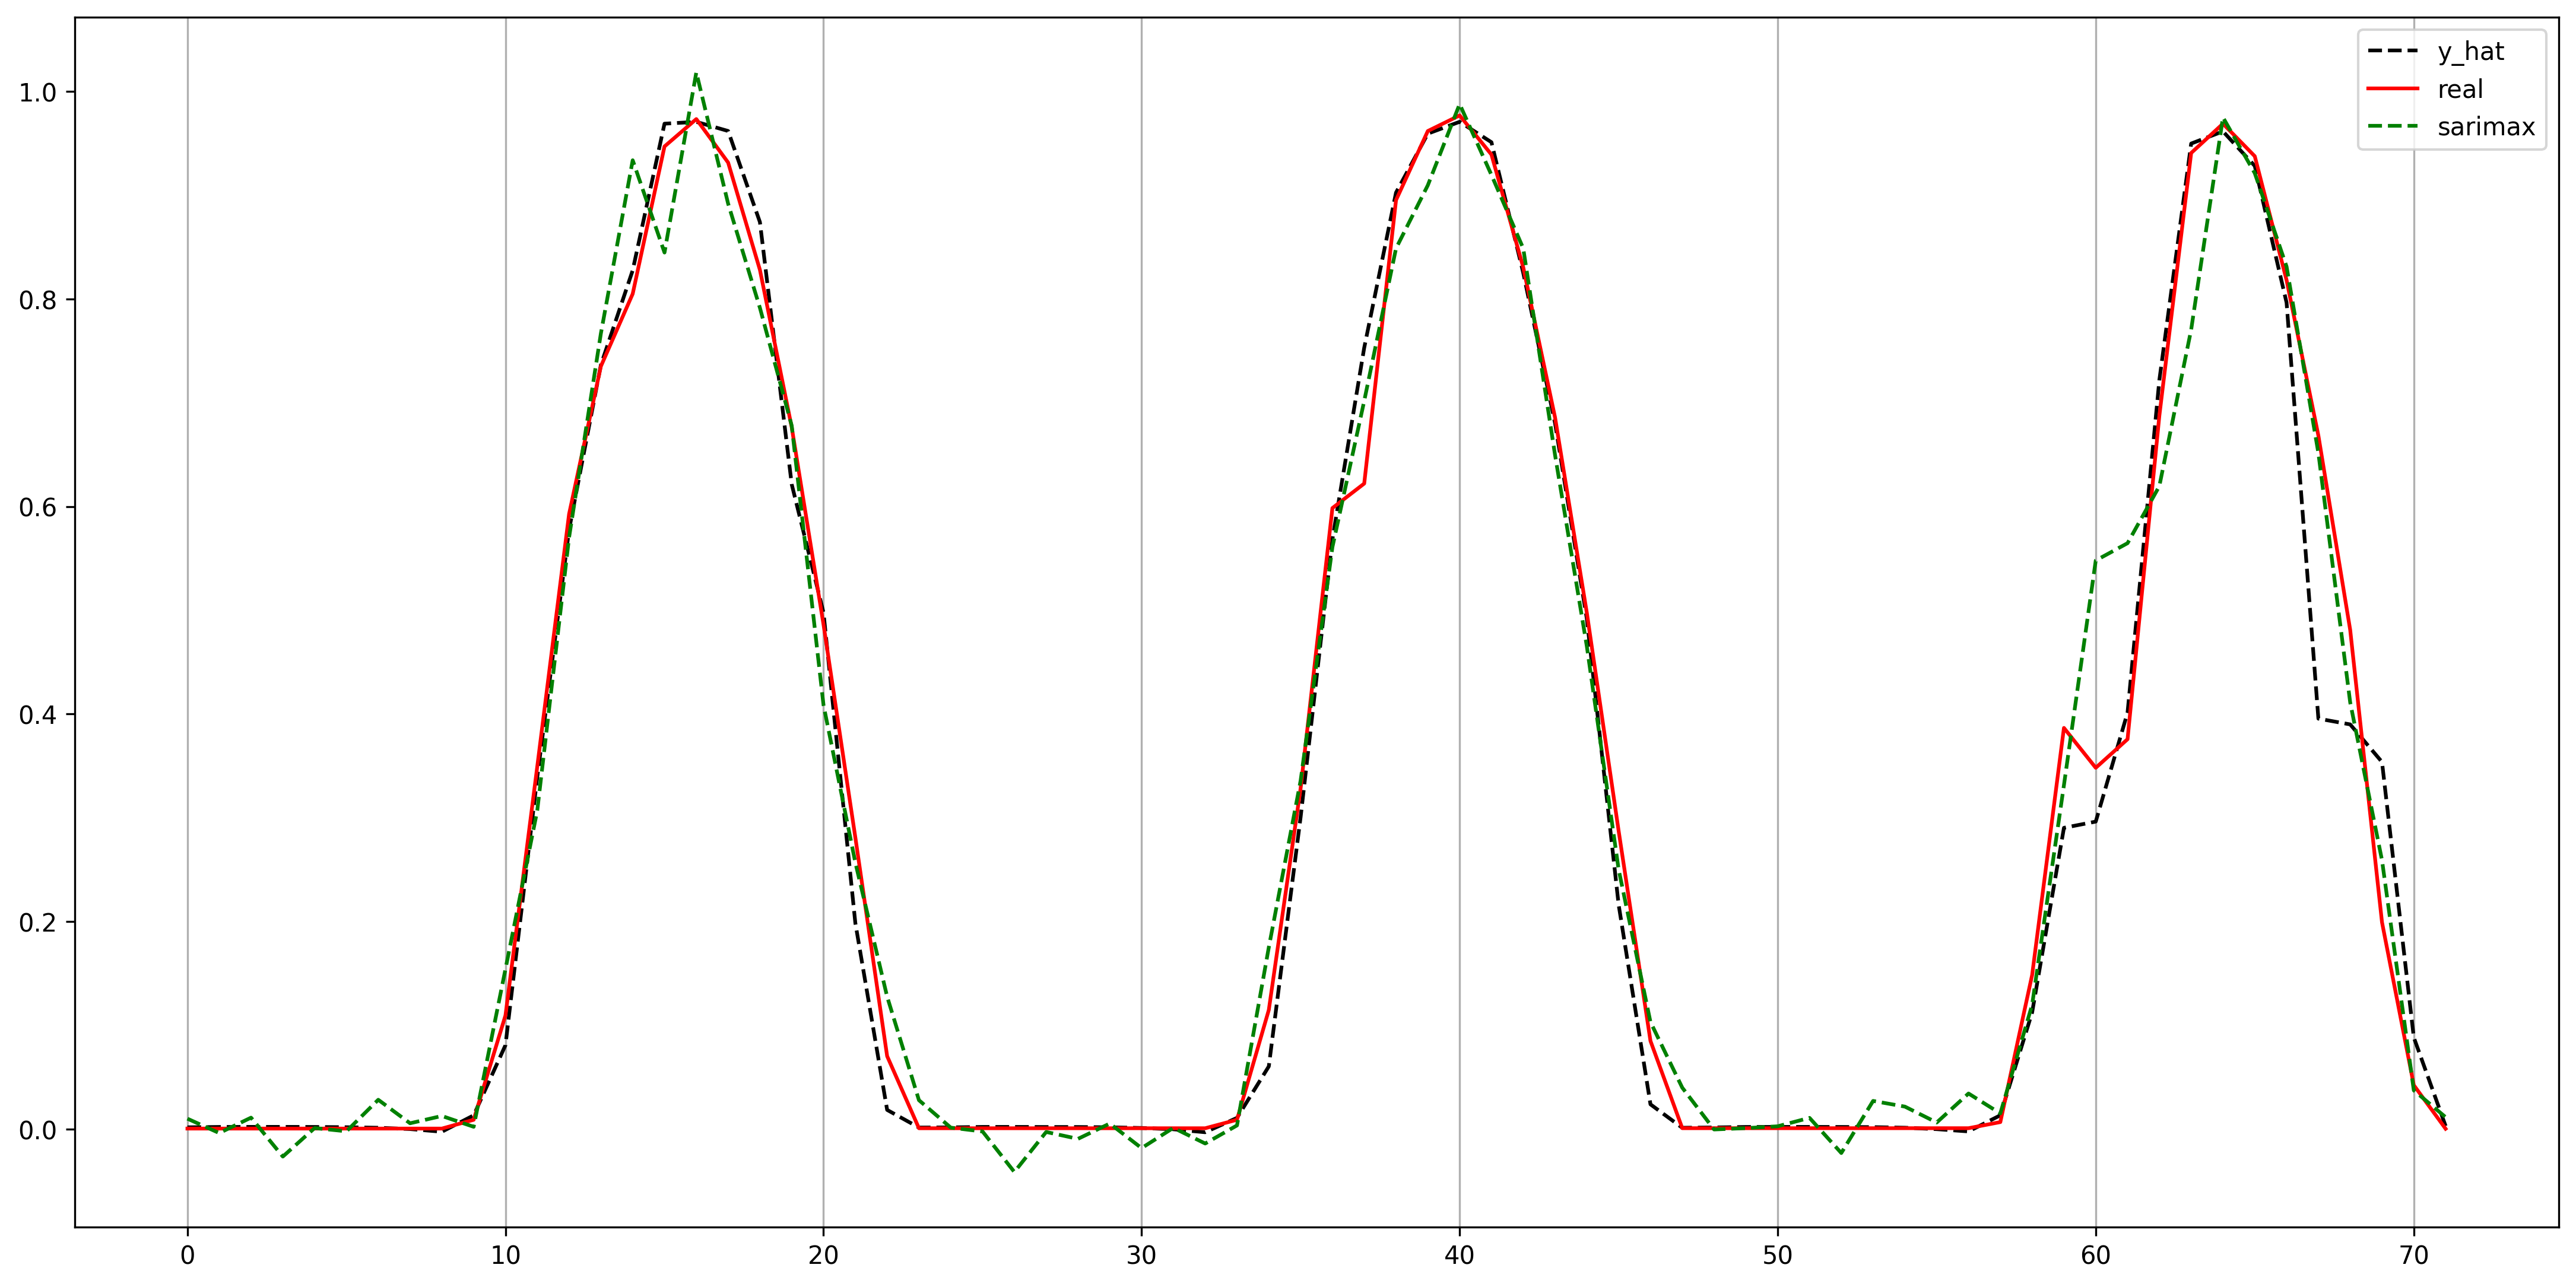

In [10]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

# LSTM + MLP

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

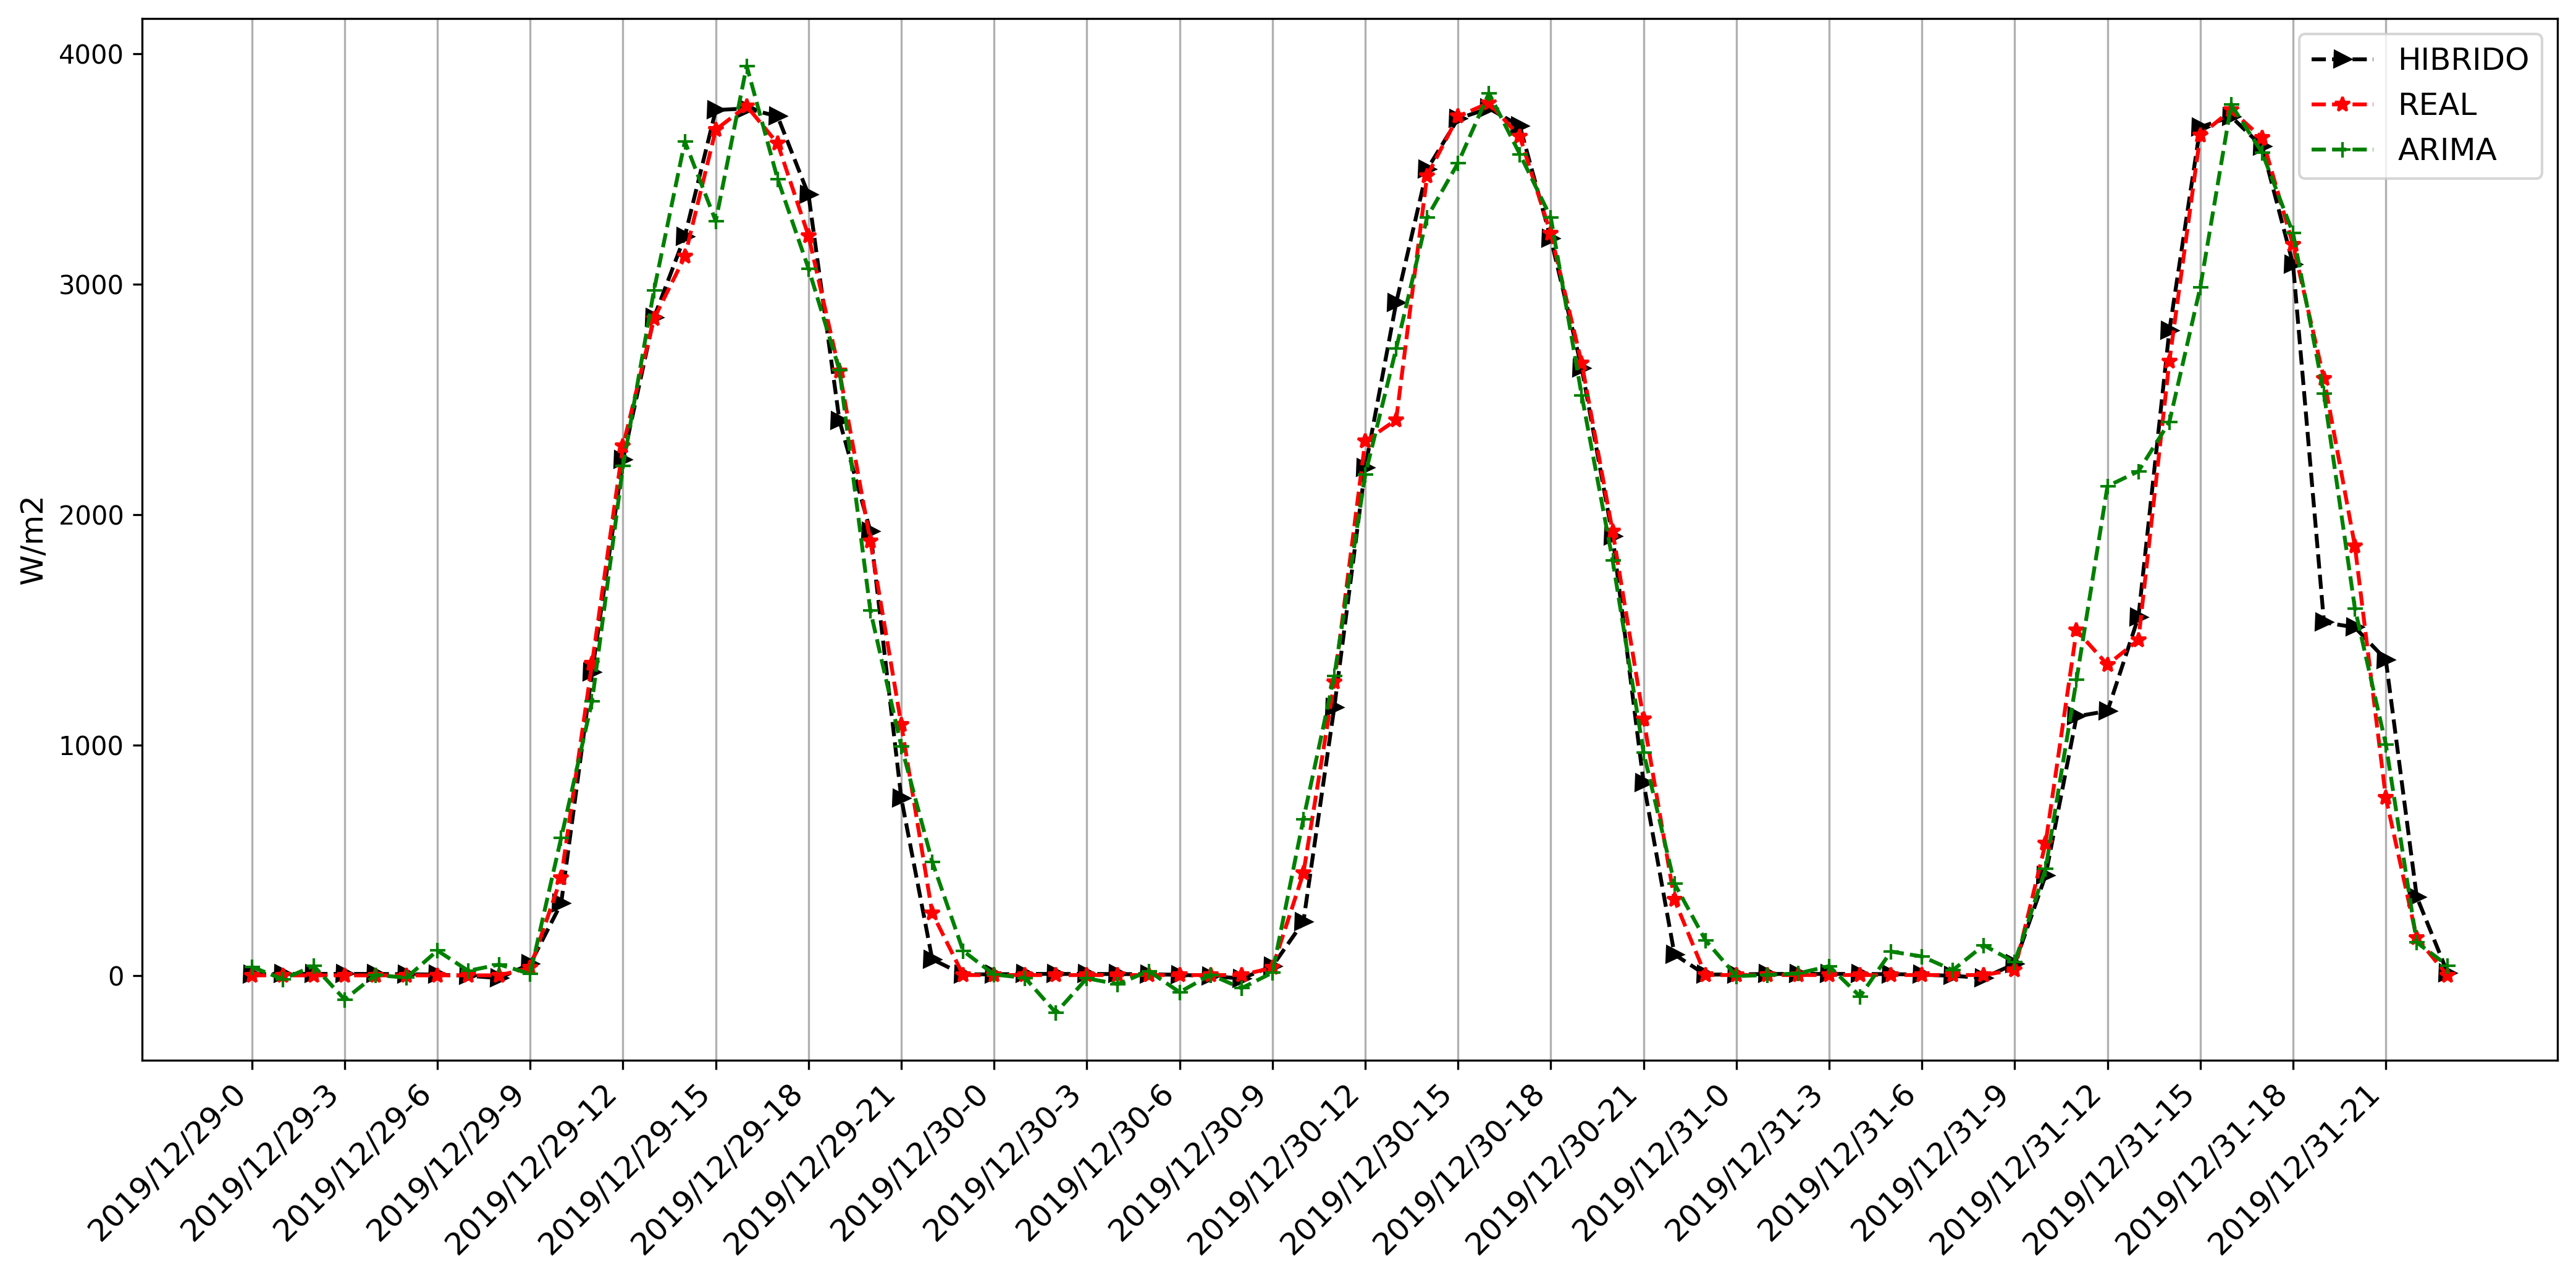

In [7]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/florianopolis_agmlpvrresidual_epoch3_pop12.png', dpi=300)

## Train

In [4]:
from mlopt.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':5, 'antTours':3, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [9]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm,1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

  0%|          | 0/3 [00:00<?, ?it/s]

2021-03-30 01:05:31,603 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:31,603: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:31,700 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:31,700: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:09:53,644 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:09:53,644: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:09:53,753 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:09:53,753: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:14:09,118 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:14:09,118: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:14:09,227 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:14:09,227: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:20:37,365 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:20:37,365: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:20:37,475 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:20:37,475: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:26:42,040 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:26:42,040: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:26:42,134 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:26:42,134: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:33:02,922 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247519A68B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:33:02,922: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247519A68B0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:33:03,016 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:33:03,016: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:33:03,126 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:33:03,126: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:09,656 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474F40FF70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:35:09,656: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474F40FF70> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:35:09,758 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:09,758: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:09,868 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:09,868: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:39:24,297 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755B50C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:39:24,297: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755B50C10> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:39:24,407 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:39:24,407: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:39:24,500 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:39:24,500: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:16,575 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002475166EA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:41:16,575: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002475166EA60> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:41:16,630 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:16,630: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:16,716 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:16,716: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:22,349 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755C84280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:47:22,349: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755C84280> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:47:22,444 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:22,444: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:22,559 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:22,559: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:49:17,408 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247571010D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:49:17,408: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247571010D0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:49:17,519 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:49:17,519: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:49:17,621 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:49:17,621: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:55:19,677 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751084AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:55:19,677: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751084AF0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:55:19,752 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:55:19,752: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:55:19,913 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:55:19,913: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:57:05,513 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247543F7DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:57:05,513: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247543F7DC0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:57:05,590 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:57:05,590: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:57:05,718 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:57:05,718: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:01:16,693 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751AEE8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:01:16,693: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751AEE8B0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:01:16,743 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:01:16,743: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:01:16,814 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:01:16,814: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:04:18,884 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755A9EDC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:04:18,884: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755A9EDC0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:04:18,930 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:04:18,930: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:04:19,012 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:04:19,012: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:05:49,060 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FBE3040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:05:49,060: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FBE3040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:05:49,107 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:05:49,107: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:05:49,201 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:05:49,201: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:08:42,393 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755D570D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:08:42,393: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755D570D0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:08:42,450 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:08:42,450: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:08:42,524 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:08:42,524: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:11:29,508 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247543194C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:11:29,508: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247543194C0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:11:29,546 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:11:29,546: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:14:43,481 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755FCCD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:14:43,481: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755FCCD30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:14:43,517 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:14:43,517: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:14:43,595 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:14:43,595: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:19:08,917 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247558AD790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:19:08,917: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247558AD790> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:19:09,201 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:19:09,201: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:19:09,532 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:19:09,532: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:20:38,326 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002471F76FEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:20:38,326: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002471F76FEE0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:20:38,773 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:20:38,773: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:20:39,151 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:20:39,151: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:25:00,366 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474F40FDC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:25:00,366: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474F40FDC0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:25:00,415 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:25:00,415: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:25:00,493 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:25:00,493: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:29:07,606 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755EC4AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:29:07,606: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024755EC4AF0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:29:07,643 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:29:07,643: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:29:07,956 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:29:07,956: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:34:10,578 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751854040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:34:10,578: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751854040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:34:10,636 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:34:10,636: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:34:10,716 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:34:10,716: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:35:41,487 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002475103AEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:35:41,487: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002475103AEE0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:35:41,542 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:35:41,542: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:35:41,619 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:35:41,619: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:36:54,205 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751BB09D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:36:54,205: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751BB09D0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:36:54,266 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:36:54,266: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:36:54,336 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:36:54,336: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:38:28,984 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247519A6310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:38:28,984: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000247519A6310> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:38:29,044 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:38:29,044: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:38:29,118 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:38:29,118: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:42:42,015 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FD220D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:42:42,015: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FD220D0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:42:42,047 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:42:42,047: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:42:42,125 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:42:42,125: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:44:03,251 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FCA44C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:44:03,251: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002474FCA44C0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:44:03,310 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:44:03,310: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:44:03,394 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:44:03,394: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:48:06,625 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751C3F9D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:48:06,625: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751C3F9D0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 02:48:06,694 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:48:06,694: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:48:06,782 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:48:06,782: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:49:28,880 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751C3FD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:49:28,880: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751C3FD30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

ACO-All Best Response: [70  4  5  4 10  3  1  0]. Fitness: 0.02797500883140181



2021-03-30 02:49:28,964 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:49:28,964: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:49:29,036 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 02:49:29,036: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 02:50:47,281 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751AC4AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 02:50:47,281: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024751AC4AF0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

In [13]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 70)            20160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 1520      
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 21,751
Trainable params: 21,751
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.utils.vis_utils import plot_model

plot_model(final_model, to_file='./resultados/lstm_model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-30 09:18:35,974 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-30 09:18:35,974: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [11]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


2021-05-25 22:53:35,902 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-25 22:53:35,902: WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-05-25 22:53:36,850 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-25 22:53:36,850: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when runn

Resultado Dados Teste!
LSTM
MAE:  0.03131835918271185
MSE:  0.0036755044898071
MAPE:  1.703408638788349


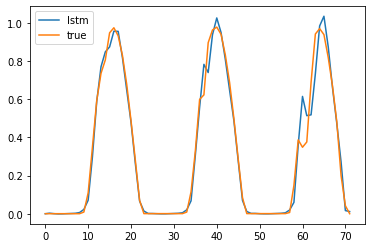

In [10]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

# CLSTM

## Train

In [17]:
from mlopt.ACOLSTM import ACOCLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':1, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [22]:
Layers_Qtd=[[50, 30, 20, 10], [20, 15, 10], [10, 20], [30, 20], [10, 5]]
ConvKernels=[[8, 12], [4, 6]]
epochs=[200]

clstmOptimizer = ACOCLSTM(X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm,
                          1 ,options_ACO=options_ACO, verbose=True)

final_model, y_hat_clstm = clstmOptimizer.optimize(Layers_Qtd = Layers_Qtd, ConvKernels = ConvKernels, epochs=epochs)

dimentions Ranges passed:  [[50, 30, 20, 10], [8, 12], [20, 15, 10], [4, 6], [10, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [30, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [10, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  

  0%|          | 0/1 [00:00<?, ?it/s]

[[50  8 20 ...  0  0  0]
 [50  8 20 ...  0  1  0]
 [50  8 20 ...  0  2  0]
 ...
 [10 12 10 ...  5  1  0]
 [10 12 10 ...  5  2  0]
 [10 12 10 ...  5  3  0]]
number of Space Possibilities (rows):  11943936
Setting fitness for
[10 12 10  4 20  0  5 30  3  3  5  5  0  0]
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 30, 'sl_func': 'relu', 'sl_refunc': 'relu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}


2021-05-26 01:45:08,626 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:45:08,626: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:45:08,626: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:45:08,966 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:45:08,966: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:45:08,966: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

Epoch 1/200
9/9 [==============================] - 136s 376ms/step - loss: 0.5099 - mse: 0.3551
Epoch 2/200
9/9 [==============================] - 3s 377ms/step - loss: 0.2110 - mse: 0.1024
Epoch 3/200
9/9 [==============================] - 3s 383ms/step - loss: 0.1934 - mse: 0.0752
Epoch 4/200
9/9 [==============================] - 3s 400ms/step - loss: 0.1915 - mse: 0.0663
Epoch 5/200
9/9 [==============================] - 3s 402ms/step - loss: 0.1916 - mse: 0.0635
Epoch 6/200
9/9 [==============================] - 3s 418ms/step - loss: 0.1785 - mse: 0.0552
Epoch 7/200
9/9 [==============================] - 6s 694ms/step - loss: 0.1733 - mse: 0.0519
Epoch 8/200
9/9 [==============================] - 4s 426ms/step - loss: 0.1606 - mse: 0.0452
Epoch 9/200
9/9 [==============================] - 3s 410ms/step - loss: 0.1527 - mse: 0.0414
Epoch 10/200
9/9 [==============================] - 6s 688ms/step - loss: 0.1389 - mse: 0.0343
Epoch 11/200
9/9 [==============================] - 4s 42

9/9 [==============================] - 1s 112ms/step - loss: 0.0627 - mse: 0.0132
Epoch 88/200
9/9 [==============================] - 1s 114ms/step - loss: 0.0603 - mse: 0.0118
Epoch 89/200
9/9 [==============================] - 1s 117ms/step - loss: 0.0565 - mse: 0.0126
Epoch 90/200
9/9 [==============================] - 1s 126ms/step - loss: 0.0574 - mse: 0.0123
Epoch 91/200
9/9 [==============================] - 1s 148ms/step - loss: 0.0595 - mse: 0.0125
Epoch 92/200
9/9 [==============================] - 1s 106ms/step - loss: 0.0578 - mse: 0.0135
Epoch 93/200
9/9 [==============================] - 1s 107ms/step - loss: 0.0529 - mse: 0.0110
Epoch 94/200
9/9 [==============================] - 1s 115ms/step - loss: 0.0541 - mse: 0.0108
Epoch 95/200
9/9 [==============================] - 1s 122ms/step - loss: 0.0565 - mse: 0.0120
Epoch 96/200
9/9 [==============================] - 1s 126ms/step - loss: 0.0539 - mse: 0.0118
Epoch 97/200
9/9 [==============================] - 1s 113ms/st

9/9 [==============================] - 1s 115ms/step - loss: 0.0534 - mse: 0.0117
Epoch 173/200
9/9 [==============================] - 1s 109ms/step - loss: 0.0471 - mse: 0.0109
Epoch 174/200
9/9 [==============================] - 1s 114ms/step - loss: 0.0466 - mse: 0.0096
Epoch 175/200
9/9 [==============================] - 1s 112ms/step - loss: 0.0453 - mse: 0.0095
Epoch 176/200
9/9 [==============================] - 1s 129ms/step - loss: 0.0475 - mse: 0.0101
Epoch 177/200
9/9 [==============================] - 1s 116ms/step - loss: 0.0447 - mse: 0.0100
Epoch 178/200
9/9 [==============================] - 1s 112ms/step - loss: 0.0463 - mse: 0.0107
Epoch 179/200
9/9 [==============================] - 1s 117ms/step - loss: 0.0516 - mse: 0.0102
Epoch 180/200
9/9 [==============================] - 1s 118ms/step - loss: 0.0462 - mse: 0.0092
Epoch 181/200
9/9 [==============================] - 1s 114ms/step - loss: 0.0503 - mse: 0.0101
Epoch 182/200
9/9 [==============================] - 1

2021-05-26 01:53:12,491 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:53:12,491: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:53:12,491: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:53:12,498 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:53:12,498: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 01:53:12,498: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

fitness is
0.04633257287892186
Setting fitness for
[10 12 10  4 10  4  3 20  2  2  5  4  2  0]
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'linear', 'fl_refunc': 'relu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'tanh', 'tl_qtn': 5, 'tl_func': 'linear', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 8s 120ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 132ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 144ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 150ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 135ms/step - loss: nan - mse: nan
Epoch 6/200
9/9 [==============================] - 1s 124ms/step - loss: nan - mse: nan
Epoch 7/200
9/9 [==============================] - 1s 121ms/step - loss: nan - mse: nan
Epoch 8/200
9/9 [

9/9 [==============================] - 1s 127ms/step - loss: nan - mse: nan
Epoch 90/200
9/9 [==============================] - 1s 125ms/step - loss: nan - mse: nan
Epoch 91/200
9/9 [==============================] - 4s 432ms/step - loss: nan - mse: nan
Epoch 92/200
9/9 [==============================] - 1s 153ms/step - loss: nan - mse: nan
Epoch 93/200
9/9 [==============================] - 4s 450ms/step - loss: nan - mse: nan
Epoch 94/200
9/9 [==============================] - 4s 461ms/step - loss: nan - mse: nan
Epoch 95/200
9/9 [==============================] - 6s 481ms/step - loss: nan - mse: nan
Epoch 96/200
9/9 [==============================] - 7s 861ms/step - loss: nan - mse: nan
Epoch 97/200
9/9 [==============================] - 4s 470ms/step - loss: nan - mse: nan
Epoch 98/200
9/9 [==============================] - 6s 775ms/step - loss: nan - mse: nan
Epoch 99/200
9/9 [==============================] - 6s 782ms/step - loss: nan - mse: nan
Epoch 100/200
9/9 [===============

9/9 [==============================] - 3s 127ms/step - loss: nan - mse: nan
Epoch 181/200
9/9 [==============================] - 4s 436ms/step - loss: nan - mse: nan
Epoch 182/200
9/9 [==============================] - 4s 461ms/step - loss: nan - mse: nan
Epoch 183/200
9/9 [==============================] - 6s 438ms/step - loss: nan - mse: nan
Epoch 184/200
9/9 [==============================] - 4s 439ms/step - loss: nan - mse: nan
Epoch 185/200
9/9 [==============================] - 4s 434ms/step - loss: nan - mse: nan
Epoch 186/200
9/9 [==============================] - 6s 442ms/step - loss: nan - mse: nan
Epoch 187/200
9/9 [==============================] - 4s 448ms/step - loss: nan - mse: nan
Epoch 188/200
9/9 [==============================] - 4s 441ms/step - loss: nan - mse: nan
Epoch 189/200
9/9 [==============================] - 4s 436ms/step - loss: nan - mse: nan
Epoch 190/200
9/9 [==============================] - 4s 425ms/step - loss: nan - mse: nan
Epoch 191/200
9/9 [=====

100%|██████████| 1/1 [18:51<00:00, 1131.81s/it]

Ant 0 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 0 move from 11589020 to 7547369
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[2.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
Pij:
[[4.2019317e-07]
 [8.4038632e-08]
 [8.4038632e-08]
 ...
 [8.4038632e-08]
 [8.4038632e-08]
 [8.4038632e-08]]
Ants now - then
[7547369] - [11589020]



2021-05-26 02:03:55,450 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:03:55,450: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:03:55,450: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:03:55,461 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:03:55,461: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:03:55,461: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't 

ACO-All Best Response: [10 12 10  4 20  0  5 30  3  3  5  5  0  0]. Fitness: 0.04633257287892186
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 30, 'sl_func': 'relu', 'sl_refunc': 'relu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
9/9 [==============================] - 14s 437ms/step - loss: 0.5123 - mse: 0.3335
Epoch 2/200
9/9 [==============================] - 4s 465ms/step - loss: 0.2058 - mse: 0.1147
Epoch 3/200
9/9 [==============================] - 6s 438ms/step - loss: 0.1950 - mse: 0.0912
Epoch 4/200
9/9 [==============================] - 4s 448ms/step - loss: 0.1863 - mse: 0.0792
Epoch 5/200
9/9 [==============================] - 4s 425ms/step - loss: 0.1710 - mse: 0.0670
Epoch 6/200
9/9 [==============================] - 6s 461ms/step - loss: 0.1596 - mse: 0.0601
Epoch 7/200
9/9 [==============================] - 4s 444ms/step - lo

9/9 [==============================] - 6s 768ms/step - loss: 0.0512 - mse: 0.0100
Epoch 84/200
9/9 [==============================] - 1s 153ms/step - loss: 0.0548 - mse: 0.0113
Epoch 85/200
9/9 [==============================] - 1s 156ms/step - loss: 0.0492 - mse: 0.0096
Epoch 86/200
9/9 [==============================] - 1s 160ms/step - loss: 0.0482 - mse: 0.0096
Epoch 87/200
9/9 [==============================] - 1s 150ms/step - loss: 0.0519 - mse: 0.0105
Epoch 88/200
9/9 [==============================] - 1s 137ms/step - loss: 0.0503 - mse: 0.0111
Epoch 89/200
9/9 [==============================] - 1s 129ms/step - loss: 0.0524 - mse: 0.0119
Epoch 90/200
9/9 [==============================] - 1s 137ms/step - loss: 0.0556 - mse: 0.0123
Epoch 91/200
9/9 [==============================] - 1s 125ms/step - loss: 0.0529 - mse: 0.0108
Epoch 92/200
9/9 [==============================] - 1s 132ms/step - loss: 0.0527 - mse: 0.0103
Epoch 93/200
9/9 [==============================] - 1s 137ms/st

9/9 [==============================] - 1s 122ms/step - loss: 0.0446 - mse: 0.0091
Epoch 169/200
9/9 [==============================] - 1s 116ms/step - loss: 0.0455 - mse: 0.0094
Epoch 170/200
9/9 [==============================] - 1s 114ms/step - loss: 0.0454 - mse: 0.0100
Epoch 171/200
9/9 [==============================] - 1s 115ms/step - loss: 0.0493 - mse: 0.0101
Epoch 172/200
9/9 [==============================] - 1s 117ms/step - loss: 0.0449 - mse: 0.0091
Epoch 173/200
9/9 [==============================] - 1s 123ms/step - loss: 0.0478 - mse: 0.0096
Epoch 174/200
9/9 [==============================] - 1s 123ms/step - loss: 0.0509 - mse: 0.0108
Epoch 175/200
9/9 [==============================] - 1s 122ms/step - loss: 0.0463 - mse: 0.0104
Epoch 176/200
9/9 [==============================] - 1s 122ms/step - loss: 0.0480 - mse: 0.0103
Epoch 177/200
9/9 [==============================] - 1s 118ms/step - loss: 0.0509 - mse: 0.0097
Epoch 178/200
9/9 [==============================] - 1

In [26]:
print("SHAPE y_hat_clstm", y_hat_clstm.shape)

print('Resultado Dados Teste!')
print('CLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_lstm))
print('MSE: ', mse(y_hat_clstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_clstm, y_test_lstm))

SHAPE y_hat_clstm (72,)
Resultado Dados Teste!
CLSTM
MAE:  0.04636005142963083
MSE:  0.005436971387520895
MAPE:  0.6717924724902097


In [27]:
final_model.save('./resultados/clstm_model')

2021-05-26 02:16:14,873 - tensorflow - INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-26 02:16:14,873: INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-26 02:16:14,873: INFO - Assets written to: ./resultados/clstm_model\assets


## Results

In [28]:
from tensorflow import keras

loadedmodel = keras.models.load_model('./resultados/clstm_model')
_, _, X_test_clstm, y_test_clstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
y_hat_clstm = loadedmodel.predict(X_test_clstm.reshape((X_test_clstm.shape[0], X_test_clstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('cLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_clstm))
print('MSE: ', mse(y_hat_clstm, y_test_clstm))
print('MAPE: ', MAPE(y_hat_clstm, y_test_clstm))

2021-05-26 02:16:23,889 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:16:23,889: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:16:23,889: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:16:23,904 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:16:23,904: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-26 02:16:23,904: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't m

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)
Resultado Dados Teste!
cLSTM
MAE:  0.04636005142963083
MSE:  0.005436971387520895
MAPE:  0.6717924724902097


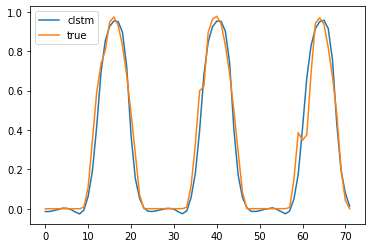

In [29]:
plt.plot(y_hat_clstm[:,0], label='clstm')
plt.plot(y_test_clstm, label='true')
plt.legend()

# Figura Unica

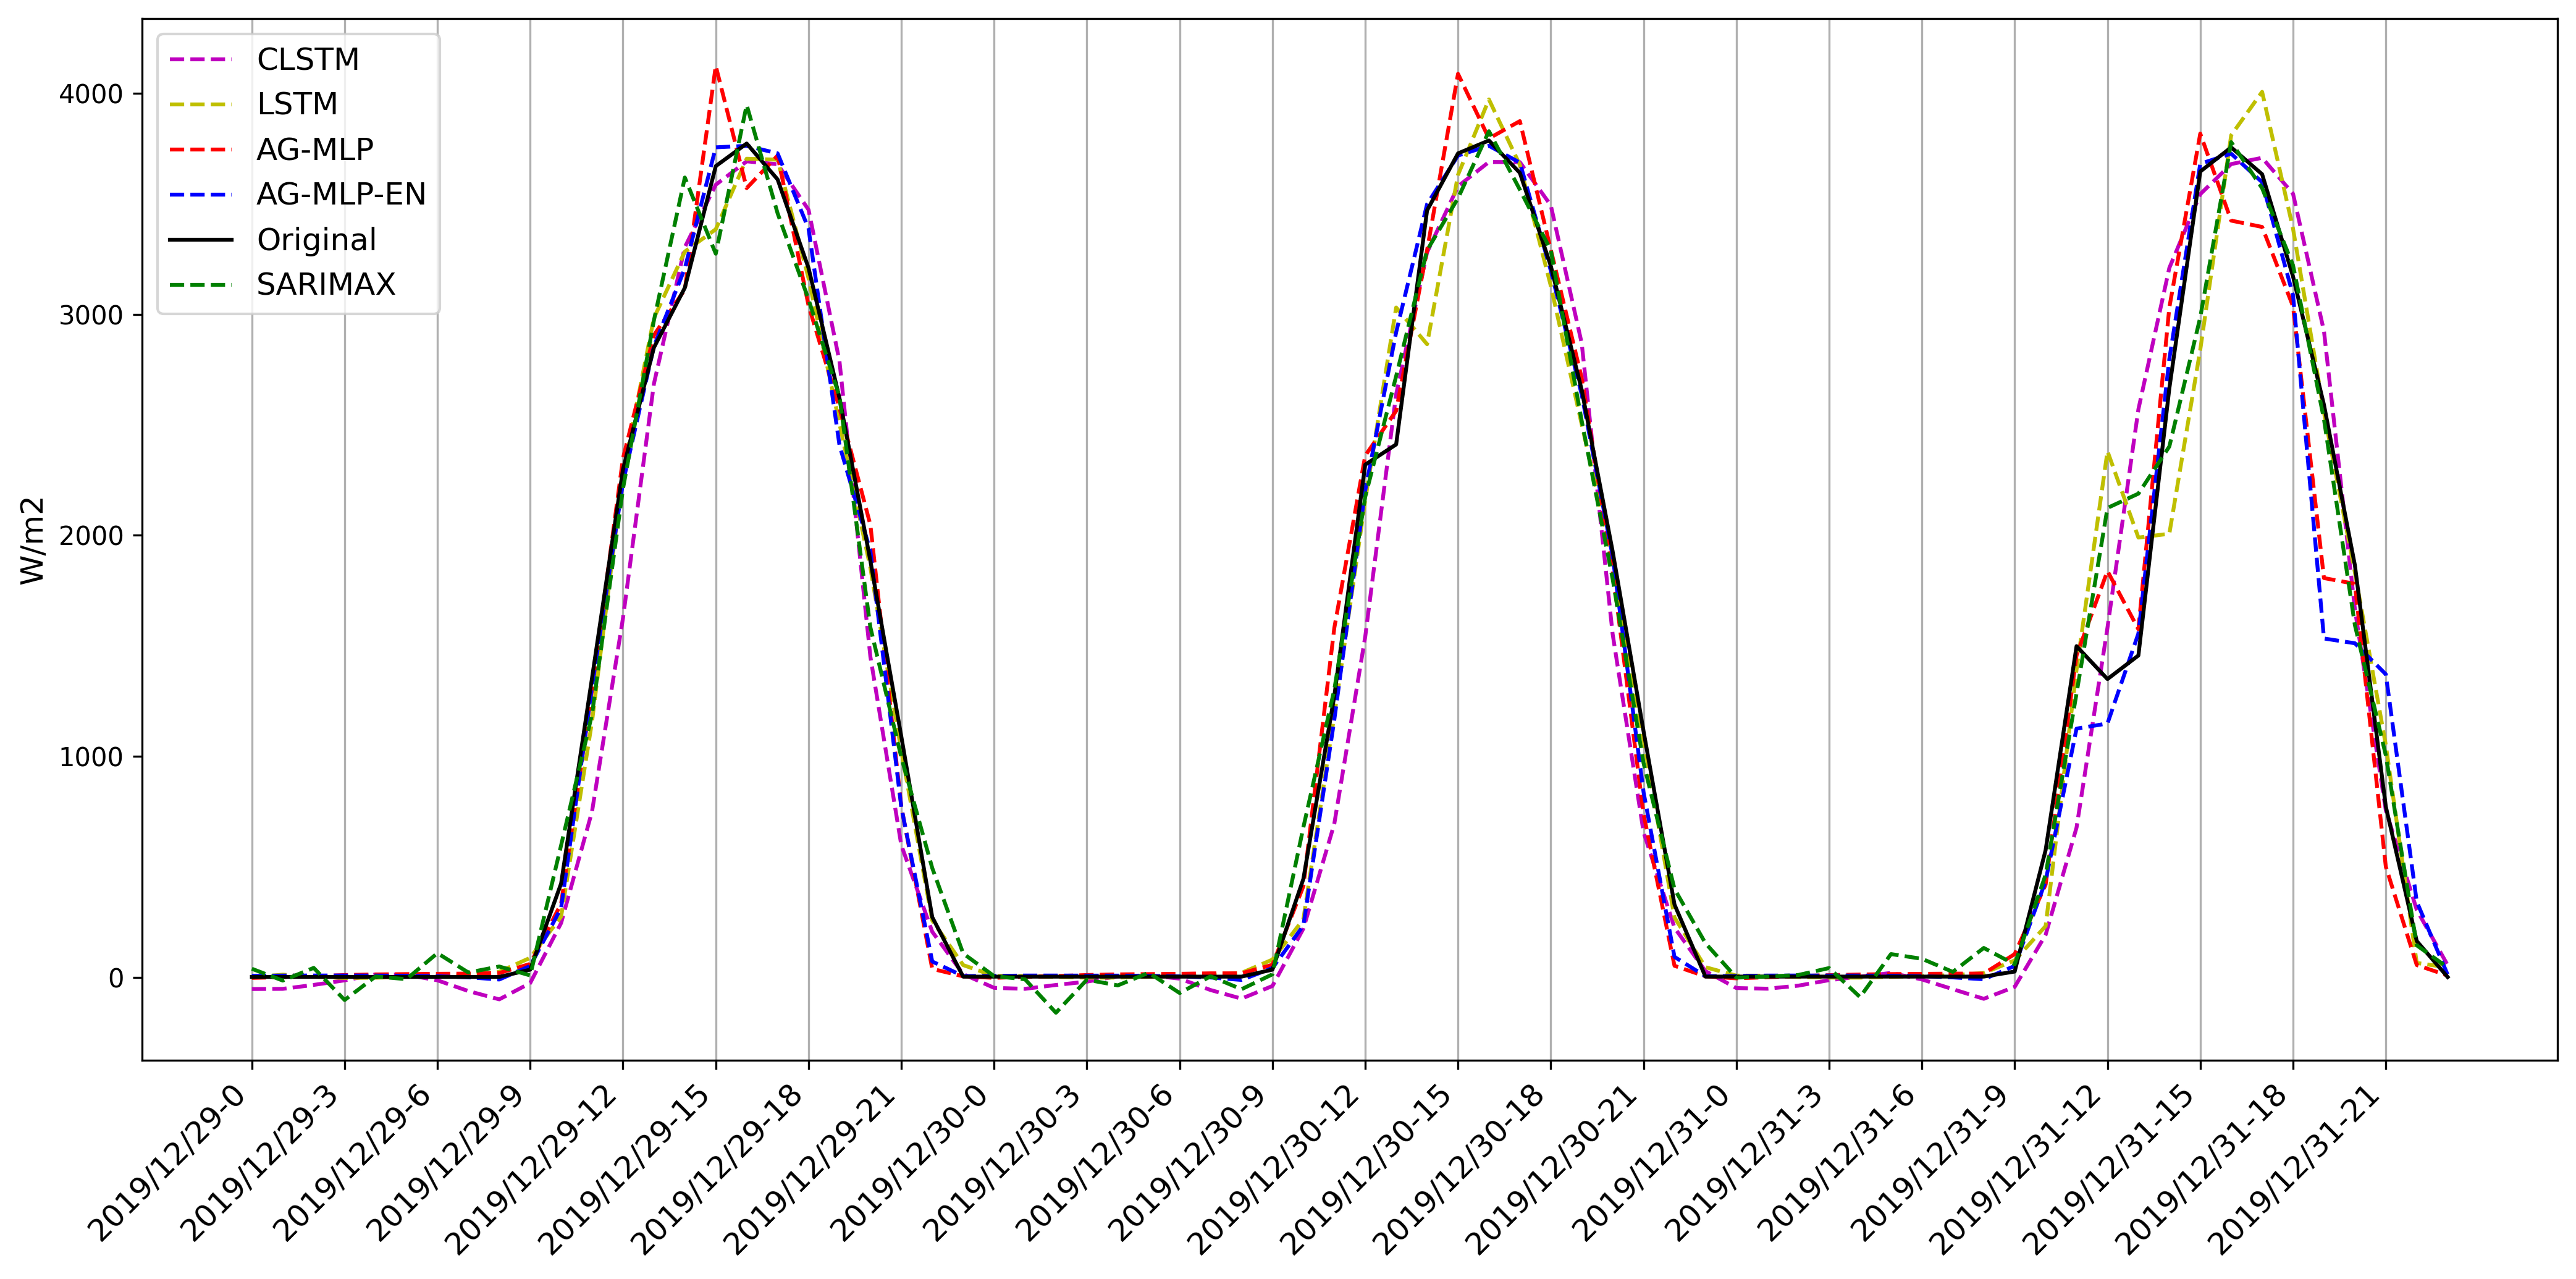

In [31]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), 'm--', label='CLSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), 'y--', label='LSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'r--', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)), 'b--',
        label='AG-MLP-EN')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Original')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids.png', dpi=300)